In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.metrics import confusion_matrix
# import sklearn
import tensorflow as tf
import matplotlib.image as mpimg
from skimage.io import imread
from sklearn.metrics import classification_report
import os

In [3]:


try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)



Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [4]:

import cv2
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input , Dense,Flatten
from tensorflow.keras.layers import Conv2D ,MaxPooling2D,Activation , Dropout,concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
# from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split



In [5]:
# df_lensed = pd.read_csv("/kaggle/input/q-tranforms-mat-gen-scripts/Lensed_full_qtransforms/Lensed_dataset_full.csv" )
# df_lensed=df_lensed.drop(columns=['Unnamed: 0'])
# df_lensed.tail()

df_lensed = pd.read_csv("/kaggle/input/skymaps-data-gaussian-noise/Lensed_df_full.csv" )
df_lensed=df_lensed.drop(columns=['Unnamed: 0'])
df_lensed['img_0']=df_lensed['img_0'].values + '_q_transform'
df_lensed['img_1']=df_lensed['img_1'].values + '_q_transform'
df_lensed.tail()

,img_0,img_1,Lensing
2806,2808_img_0_q_transform,2808_img_1_q_transform,1
2807,2809_img_0_q_transform,2809_img_1_q_transform,1
2808,2810_img_0_q_transform,2810_img_1_q_transform,1
2809,2811_img_0_q_transform,2811_img_1_q_transform,1
2810,2812_img_0_q_transform,2812_img_1_q_transform,1


In [6]:
df_unlensed = pd.read_csv("/kaggle/input/skymaps-data-gaussian-noise/Unlensed_df_train.csv" )

df_unlensed=df_unlensed.drop(columns=['Unnamed: 0'])
df_unlensed.tail()



,img_0,img_1,Lensing
9995,441,32,0
9996,300,448,0
9997,286,316,0
9998,443,363,0
9999,59,240,0


In [7]:
# img=imread('/kaggle/input/q-tranforms-mat-gen-scripts/'+img_0_paths[0]+'.png')[:,:,:3].reshape([224, 397,3])
# from skimage.transform import rescale, resize, downscale_local_mean
# image_rescaled = resize(img,(224,224))#rescale(img, scale=0.5)
# plt.imshow(img)

# plt.figure()
# plt.imshow(image_rescaled)

In [8]:
# from skimage.transform import rescale, resize, downscale_local_mean
def read_spectograms(file_paths, img_rows, img_cols, as_gray, channels): 
    images = []  
    for file_path in file_paths:
        img = cv2.imread(file_path)
        img=cv2.resize(img,(img_rows,img_cols))
        images.append(img)#, as_grey = as_gray))
  
    images = np.asarray(images, dtype=np.float32)
    
  # normalize
    images = images / np.max(images)
   
  # reshape to match Keras expectaions
    images = images.reshape(images.shape[0], img_rows, img_cols, channels)
    
    return images

In [11]:
# size of the training dataset
size=1410 # for each lensed and unlensed

# to choose test dataset different from the train one remember this random state.
df_unlensed=df_unlensed.sample(frac = 1,random_state = 42).reset_index(drop = True)[:size]
df_lensed=df_lensed[:size]

# training data set
df_train = pd.concat([df_lensed,df_unlensed],ignore_index = True)
df_train=df_train.sample(frac = 1,random_state = 42).reset_index(drop = True)[:2*size]
df_train

,img_0,img_1,Lensing
0,1088_img_0_q_transform,1088_img_1_q_transform,1
1,772_img_0_q_transform,772_img_1_q_transform,1
2,384,416,0
3,1192_img_0_q_transform,1192_img_1_q_transform,1
4,424,221,0
...,...,...,...
2795,457,270,0
2796,1095_img_0_q_transform,1095_img_1_q_transform,1
2797,1130_img_0_q_transform,1130_img_1_q_transform,1
2798,1294_img_0_q_transform,1294_img_1_q_transform,1


In [12]:
from numpy.core.defchararray import add
# load training dataset
as_gray = False#True
in_channel = 3

if as_gray:
    in_channel = 1
    
# height and width
img_rows , img_cols = 128,128
#hyperparameters
batch_size = 20
epochs = 32

input_shape = (img_rows,img_cols , in_channel)
input_img = Input(shape = input_shape)
det='H1'


# prefix_paths= df_train.Lensing.values
# prefix_paths=prefix_paths.astype('U256')
# prefix_paths[prefix_paths=='1'] = 'Lensed_full_qtransforms/' + det + '/'
# prefix_paths[prefix_paths=='0'] = 'Unlensed_full_qtransforms/' + det + '/'

# img_0_paths=prefix_paths+df_train.img_0.values
# img_1_paths=prefix_paths+df_train.img_1.values
# # 0']=df_lensed['img_0'].values + '_q_transform'
# # # df_lensed['img_1']=df_lensed['img_1'].values + '_q_transform'
# # # df_lensed.tail()
# # # df_lensed['img_

prefix_paths= df_train.Lensing.values.astype(str)
prefix_paths=prefix_paths.astype('U256')
prefix_paths[prefix_paths=='1'] = 'Lensed_full_qtransforms/' + det + '/' + 'Lensed '
prefix_paths[prefix_paths=='0'] = 'Unlensed_full_qtransforms/' + det + '/' + 'Unlensed '

img_0_paths=add(add('/kaggle/input/q-tranforms-mat-gen-scripts/',add(prefix_paths,df_train.img_0.values.astype(str))),'.png')
img_1_paths=add(add('/kaggle/input/q-tranforms-mat-gen-scripts/',add(prefix_paths,df_train.img_1.values.astype(str))),'.png')

In [13]:
x_train_0 = read_spectograms(img_0_paths,img_rows,img_cols,as_gray,in_channel)

In [14]:
x_train_0.shape

(2800, 128, 128, 3)

In [15]:
x_train_1 = read_spectograms(img_1_paths,img_rows,img_cols,as_gray,in_channel)



In [17]:
labels = df_train.Lensing.values
x_comp1=np.array([(x_train_0[idx,:,:,:] + x_train_1[idx,:,:,:])/2 for idx in range(2*size)])
del x_train_0 
del x_train_1
x_train ,x_val,y_train,y_val = train_test_split(x_comp1,labels,test_size=0.2,random_state = 42)
#np.reshape(x_comp,(2*size,img_rows , img_cols,2))
x_comp1.shape
del x_comp1

In [18]:
from keras.layers import LeakyReLU
with strategy.scope():
    pre_model = tf.keras.applications.DenseNet201(
        input_shape=(img_rows , img_cols, 3),
        weights='imagenet',
        include_top=False
    )
    pre_model.trainable = True
    model = tf.keras.Sequential([
        pre_model,
        tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dense(512,activation='relu', kernel_initializer='he_uniform',kernel_regularizer=l2(0.002)),
        tf.keras.layers.Dense(256, activation='relu',kernel_initializer='he_uniform',kernel_regularizer=l2(0.005)),
#         tf.keras.layers.LeakyReLU(), 
#         tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
        
    model.compile(loss = "binary_crossentropy",optimizer = 'adam' ,metrics = ["accuracy"])
    
    model.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               491776    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 18,814,017
Trainable params: 18,584,961
Non-trainable params: 229,056
_________________________________________________________________


In [19]:
import time
import datetime
f=pre_model.name.replace('.','_') + '_det_' + det + "(128*128)-H1.h5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=15)
mc_trained = ModelCheckpoint('trained_'+f,monitor = "val_accuracy",mode="max",verbose=1,save_best_only=True)
mc_untrained = ModelCheckpoint('untrained_'+f,monitor = "val_accuracy",mode="max",verbose=1,save_best_only=True)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

start_time=time.time()

def lrfn(epoch):
    LR_START = 0.00001
    LR_MAX = 0.00005 * strategy.num_replicas_in_sync
    LR_MIN = 0.00001
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .8
    
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

if pre_model.trainable == True :
    history = model.fit(x_train[:,:,:,:3],y_train,batch_size=32,epochs=15,callbacks=[lr_schedule,mc_trained,es],verbose=1, validation_data=(x_val, y_val),shuffle = True)
    
#     model.save('trained_'+f)
elif pre_model.trainable == False :
    history = model.fit(x_train[:,:,:,:3],y_train,batch_size=32,epochs=15,callbacks=[lr_schedule,mc_untrained,es],verbose=1, validation_data=(x_val, y_val),shuffle = True)
#     model.save + f)
end_time=time.time()
print("Time Taken: ",end_time-start_time)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/15
70/70 [==============================] - ETA: 0s - loss: 3.1067 - accuracy: 0.6902
Epoch 00001: val_accuracy improved from -inf to 0.51429, saving model to trained_densenet201_det_H1(128*128)-H1.h5
70/70 [==============================] - 46s 662ms/step - loss: 3.1067 - accuracy: 0.6902 - val_loss: 3.2044 - val_accuracy: 0.5143 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
Epoch 2/15
70/70 [==============================] - ETA: 0s - loss: 2.7194 - accuracy: 0.7933
Epoch 00002: val_accuracy improved from 0.51429 to 0.73036, saving model to trained_densenet201_det_H1(128*128)-H1.h5
70/70 [==============================] - 19s 264ms/step - loss: 2.7194 - accuracy: 0.7933 - val_loss: 2.6050 - val_accuracy: 0.7304 - lr: 8.8000e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
Epoch 3/15
70/70 [==============================] - ETA: 0s - loss: 2

In [20]:
#deleting x train for loading test data
del x_train

In [21]:
# size_test = 300
# df_lensed = pd.read_csv("/kaggle/input/q-tranforms-mat-gen-scripts/Lensed_full_qtransforms/Lensed_dataset_full.csv" )
# df_lensed=df_lensed.drop(columns=['Unnamed: 0'])

# size_test = 400
# df_lensed=df_lensed[-size_test:]


# df_unlensed_test = pd.read_csv("/kaggle/input/skymaps-data-gaussian-noise/Unlensed_df_test.csv" )

# df_unlensed_test = df_unlensed_test.drop(columns=['Unnamed: 0']).reset_index(drop = True)[:size_test]
# df_test = pd.concat([df_lensed,df_unlensed_test],ignore_index = True)
# df_test=df_test.sample(frac = 1,random_state=20).reset_index(drop = True)
# df_test



# # df_unlensed = pd.read_csv("/kaggle/input/q-tranforms-mat-gen-scripts/Unlensed_full_qtransforms/Unlensed_dataset_full.csv" )
# # df_unlensed=df_unlensed.drop(columns=['Unnamed: 0'])




# df_unlensed_test=df_unlensed[500500:500800]
# df_lensed_test=df_lensed[2200:2500]
# df_test = pd.concat([df_lensed_test,df_unlensed_test],ignore_index = True)
# df_test=df_test.sample(frac = 1,random_state = 42).reset_index(drop = True)
# df_test

In [22]:
size_test = 400
df_lensed=df_lensed[-size_test:]


df_unlensed_test = pd.read_csv("/kaggle/input/skymaps-data-gaussian-noise/Unlensed_df_test.csv" )

df_unlensed_test = df_unlensed_test.drop(columns=['Unnamed: 0']).reset_index(drop = True)[:size_test]
df_test = pd.concat([df_lensed,df_unlensed_test],ignore_index = True)
df_test=df_test.sample(frac = 1,random_state=20).reset_index(drop = True)
df_test

,img_0,img_1,Lensing
0,1267_img_0_q_transform,1267_img_1_q_transform,1
1,894,959,0
2,1350_img_0_q_transform,1350_img_1_q_transform,1
3,1062_img_0_q_transform,1062_img_1_q_transform,1
4,581,962,0
...,...,...,...
795,1218_img_0_q_transform,1218_img_1_q_transform,1
796,1223_img_0_q_transform,1223_img_1_q_transform,1
797,1271_img_0_q_transform,1271_img_1_q_transform,1
798,621,712,0


In [23]:
prefix_paths= df_test.Lensing.values.astype(str)
prefix_paths=prefix_paths.astype('U256')
prefix_paths[prefix_paths=='1'] = 'Lensed_full_qtransforms/' + det + '/' + 'Lensed '
prefix_paths[prefix_paths=='0'] = 'Unlensed_full_qtransforms/' + det + '/' + 'Unlensed '

img_0_paths=add(add('/kaggle/input/q-tranforms-mat-gen-scripts/',add(prefix_paths,df_test.img_0.values.astype(str))),'.png')
img_1_paths=add(add('/kaggle/input/q-tranforms-mat-gen-scripts/',add(prefix_paths,df_test.img_1.values.astype(str))),'.png')

In [24]:
# prefix_paths= df_test.Lensing.values
# prefix_paths=prefix_paths.astype('U256')
# prefix_paths[prefix_paths=='1'] = 'Lensed_full_qtransforms/' + det + '/'
# prefix_paths[prefix_paths=='0'] = 'Unlensed_full_qtransforms/' + det + '/'

# img_0_paths=prefix_paths+df_test.img_0.values
# img_1_paths=prefix_paths+df_test.img_1.values





# # prefix_paths= df_test.Lensing.values.astype(str)
# # prefix_paths=prefix_paths.astype('U256')
# # prefix_paths[prefix_paths=='1'] = 'Lensed_full_qtransforms/' + det + '/' + 'Lensed '
# # prefix_paths[prefix_paths=='0'] = 'Unlensed_full_qtransforms/' + det + '/' + 'Unlensed '

# # img_0_paths=add(add('/kaggle/input/q-tranforms-mat-gen-scripts/',add(prefix_paths,df_test.img_0.values.astype(str))),'.png')
# # img_1_paths=add(add('/kaggle/input/q-tranforms-mat-gen-scripts/',add(prefix_paths,df_test.img_1.values.astype(str))),'.png')




In [25]:
x_test_0 = read_spectograms(img_0_paths,img_rows,img_cols,as_gray,in_channel)

In [26]:
x_test_1 = read_spectograms(img_1_paths,img_rows,img_cols,as_gray,in_channel)

In [27]:
y_test = df_test.Lensing.values
x_test=np.array([(x_test_0[idx,:,:,:] + x_test_1[idx,:,:,:])/2 for idx in range(2*size_test)])
del x_test_0 
del x_test_1
# x_train ,x_val,y_train,y_val = train_test_split(x_comp1,labels,test_size=0.2,random_state = 42)
#np.reshape(x_comp,(2*size,img_rows , img_cols,2))
x_test.shape
# del x_comp1

(800, 128, 128, 3)

In [28]:
final_loss , final_acc = model.evaluate(x_test[:,:,:,:3],y_test,verbose = 1)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))



25/25 [==============================] - 1s 41ms/step - loss: 0.6038 - accuracy: 0.9100
Final loss: 0.603784, final accuracy: 0.910000


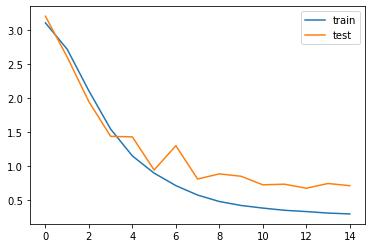

In [29]:
# plot training history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



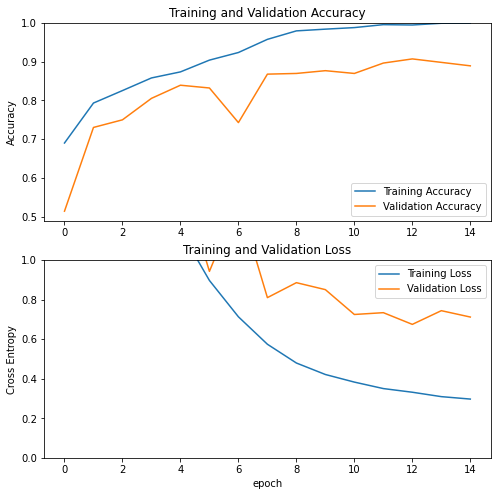

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()



In [31]:
y_predict = model.predict_classes(x_test[:,:,:,:3])

In [32]:
# y_pred_labels = np.argmax(y_predict, axis=1) 

##Confusion matrix
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
results = confusion_matrix(y_test, y_predict) 
  
print ('Confusion Matrix :')
print(results) 
print("******************")
print ('Accuracy Score :',accuracy_score(y_test, y_predict)) 
print("******************")
print ('Report : ')
print (classification_report(y_test,y_predict)) 

Confusion Matrix :
[[336  64]
 [  8 392]]
******************
Accuracy Score : 0.91
******************
Report : 
              precision    recall  f1-score   support

           0       0.98      0.84      0.90       400
           1       0.86      0.98      0.92       400

    accuracy                           0.91       800
   macro avg       0.92      0.91      0.91       800
weighted avg       0.92      0.91      0.91       800



In [33]:
## Roc curve
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_predict)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.91

Text(0.5, 0, 'False Positive Rate')

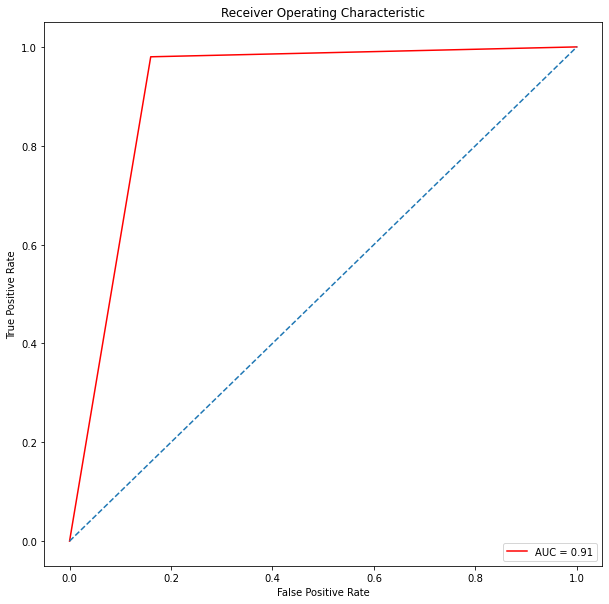

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

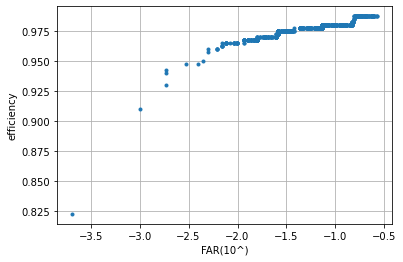

In [35]:
y_predict_prob = model.predict_proba(x_test[:,:,:,:3])
lens_size=y_test[y_test==1].sum()
size=y_test.shape[0]
efficiency=[]
FAR=[]
for thr in np.arange(0.1,1,0.001):
    y_pred=y_predict_prob>thr
    results = confusion_matrix(y_test, y_pred) 
    efficiency.append(results[1,1]/lens_size)
    FAR.append(2*results[0,1]/(size-lens_size))
#print ('Confusion Matrix :')
#print(results)
#print ('Efficiency, FAR :')

plt.plot(np.log(FAR),efficiency,'.')
plt.xlabel('FAR(10^)')
#plt.xscale('log')
plt.ylabel('efficiency')
plt.grid()
plt.show()

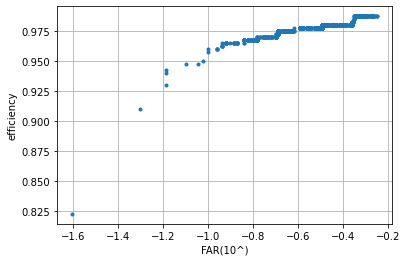

In [36]:
y_predict_prob = model.predict_proba(x_test[:,:,:,:3])
lens_size=y_test[y_test==1].sum()
size=y_test.shape[0]
efficiency=[]
FAR=[]
for thr in np.arange(0.1,1,0.001):
    y_pred=y_predict_prob>thr
    results = confusion_matrix(y_test, y_pred) 
    efficiency.append(results[1,1]/lens_size)
    FAR.append(2*results[0,1]/(size-lens_size))
#print ('Confusion Matrix :')
#print(results)
#print ('Efficiency, FAR :')

plt.plot(np.log10(FAR),efficiency,'.')
plt.xlabel('FAR(10^)')
#plt.xscale('log')
plt.ylabel('efficiency')
plt.grid()
plt.show()

